In [43]:
# ========
# Imports
# ========
import os
import cv2
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [45]:
# =====================================
# Mount Google Drive and Set Paths
# =====================================
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# =====================================
# Download data from Kaggle
# =====================================
data_path = kagglehub.dataset_download("lbquctrung/worksite-safety-monitoring-dataset")
TEST_DIR = os.path.join(data_path, "Worksite-Safety-Monitoring-Dataset/test")
TRAIN_DIR = os.path.join(data_path, "Worksite-Safety-Monitoring-Dataset/train")
VALID_DIR = os.path.join(data_path, "Worksite-Safety-Monitoring-Dataset/valid")

Mounted at /content/drive/
Using Colab cache for faster access to the 'worksite-safety-monitoring-dataset' dataset.


In [48]:
os.chdir("/content/drive/MyDrive/Safety_Monitoring")

In [135]:
!git init
!git add .
!git branch -m main
!git remote add origin https://github.com/ashishthapaweb/worksite-safety-monitoring-with-image-classification.git
!git commit -m "First Commit"

Reinitialized existing Git repository in /content/drive/MyDrive/Safety_Monitoring/.git/
On branch main
nothing to commit, working tree clean


In [136]:
!git config --global user.email "ashishthapaweb@gmail.com"
!git config --global user.name "Ashish Thapa"

In [ ]:
!git add -A
!git commit -m "Clean snapshot without secrets"  # if nothing to commit it will say so

!git checkout --orphan clean-main
!git add -A
!git commit -m "Initial clean commit without secrets"
!git branch -M clean-main main
!git remote set-url origin https://github.com/ashishthapaweb/worksite-safety-monitoring-with-image-classification.git
!git push -u origin main --force-with-lease

In [142]:
!git push -u origin main --force

Enumerating objects: 31, done.
Counting objects: 100% (31/31), done.
Delta compression using up to 2 threads
Compressing objects: 100% (31/31), done.
Writing objects: 100% (31/31), 86.53 MiB | 12.79 MiB/s, done.
Total 31 (delta 18), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (18/18), done.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File safety_classifier_resnet50.pth is 90.00 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote: 

In [ ]:
# =====================================
# Load Images
# =====================================

def load_files(img_dir):
    for each in os.listdir(img_dir):
      if each == "safe":
        safe_pics = sorted([os.path.join(img_dir, each, file) for file in os.listdir(os.path.join(img_dir, each))])
      else:
        unsafe_pics = sorted([os.path.join(img_dir, each, file) for file in os.listdir(os.path.join(img_dir, each))])

    images = {"safe": safe_pics, "unsafe": unsafe_pics}
    return images

TEST_IMGS = load_files(TEST_DIR)
TRAIN_IMGS = load_files(TRAIN_DIR)
VALID_IMGS = load_files(VALID_DIR)

Load Images

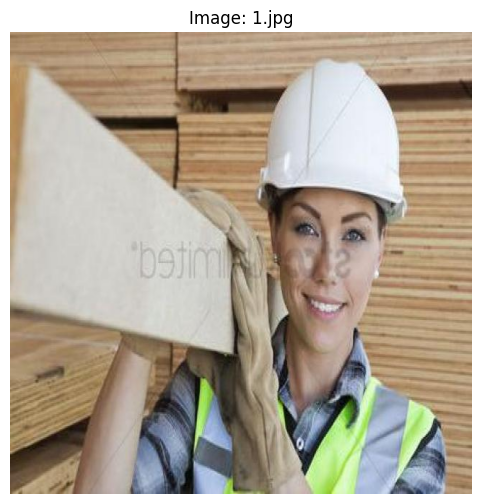

In [ ]:
# =========================
# Visualize Sample Image
# =========================
def visualize_sample(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis("off")
    plt.show()

visualize_sample(VALID_IMGS['safe'][0])

In [ ]:
# =====================================
# Custom Dataset Preparation
# =====================================

class SafetyDataset(Dataset):
    def __init__(self, image_dict, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for label, paths in image_dict.items():
            self.image_paths.extend(paths)
            self.labels.extend([0 if label == "safe" else 1] * len(paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [ ]:
# =====================================
# Define Transforms and Loaders
# =====================================

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = SafetyDataset(TRAIN_IMGS, transform)
valid_ds = SafetyDataset(VALID_IMGS, transform)
test_ds = SafetyDataset(TEST_IMGS, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [ ]:
# =====================================
# Use Pretrained ResNet-50
# =====================================

from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [ ]:
# ===================
# Train the model
# ==================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
# ======================
# Evaluate the model
# ======================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    print("Accuracy:", accuracy_score(all_labels, all_preds))
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=["safe", "unsafe"]))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


In [ ]:
# =====================================
# Train the model
# =====================================
train_model(model, epochs=5)

Epoch 1/5, Loss: 0.4269
Epoch 2/5, Loss: 0.0925
Epoch 3/5, Loss: 0.0493
Epoch 4/5, Loss: 0.0211
Epoch 5/5, Loss: 0.0096


In [ ]:
# =====================================
# Evaluate Performance
# =====================================
evaluate_model(test_loader)

Accuracy: 0.905
Classification Report:
               precision    recall  f1-score   support

        safe       0.87      0.95      0.91       100
      unsafe       0.95      0.86      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200

Confusion Matrix:
 [[95  5]
 [14 86]]


In [ ]:
# ======================
# Save the model
# ======================
path = "/content/drive/MyDrive/Safety_Monitoring"
os.makedirs(path, exist_ok=True)
save_path = os.path.join(path, "safety_classifier_resnet50.pth")
torch.save(model.state_dict(), save_path)

In [ ]:
# ======================
# Load the model
# ======================
from torchvision import models

# Recreate the model structure
loaded_model = models.resnet50(pretrained=False)
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 2)
loaded_model.load_state_dict(torch.load(save_path))
loaded_model = loaded_model.to(device)
loaded_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# ======================
# Make prediction
# ======================

def predict_image(image_path, model, transform):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        label = "safe" if predicted.item() == 0 else "unsafe"
    return label

In [ ]:
image_path = VALID_IMGS['unsafe'][0]  # or any other image path
predicted_label = predict_image(image_path, loaded_model, transform)
print(f"Predicted class: {predicted_label}")

Predicted class: safe


In [ ]:
import random
import matplotlib.pyplot as plt
import os

def show_predictions_grid(model, transform):
    model.eval()
    sets = [("Train", TRAIN_IMGS), ("Validation", VALID_IMGS), ("Test", TEST_IMGS)]
    fig, axs = plt.subplots(3, 3, figsize=(8, 10))  # 3x3 grid

    for row_idx, (set_name, dataset_dict) in enumerate(sets):
        # Combine safe & unsafe, shuffle, pick 3
        all_paths = dataset_dict['safe'] + dataset_dict['unsafe']
        random.shuffle(all_paths)
        sample_paths = all_paths[:3]

        for col_idx, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            prediction = predict_image(img_path, model, transform)

            # Extract info
            file_name = os.path.basename(img_path)
            class_folder = os.path.basename(os.path.dirname(img_path))
            dataset_folder = set_name

            # Display
            axs[row_idx, col_idx].imshow(img_rgb)
            axs[row_idx, col_idx].set_title(
                f"{file_name} ({dataset_folder}/{class_folder})\nTrue: {class_folder} | Pred: {prediction}",
                color="green" if class_folder == prediction else "red",
                fontsize=9
            )
            axs[row_idx, col_idx].axis('off')

        # Label the row
        axs[row_idx, 0].set_ylabel(set_name, fontsize=14)

    plt.tight_layout()
    plt.show()

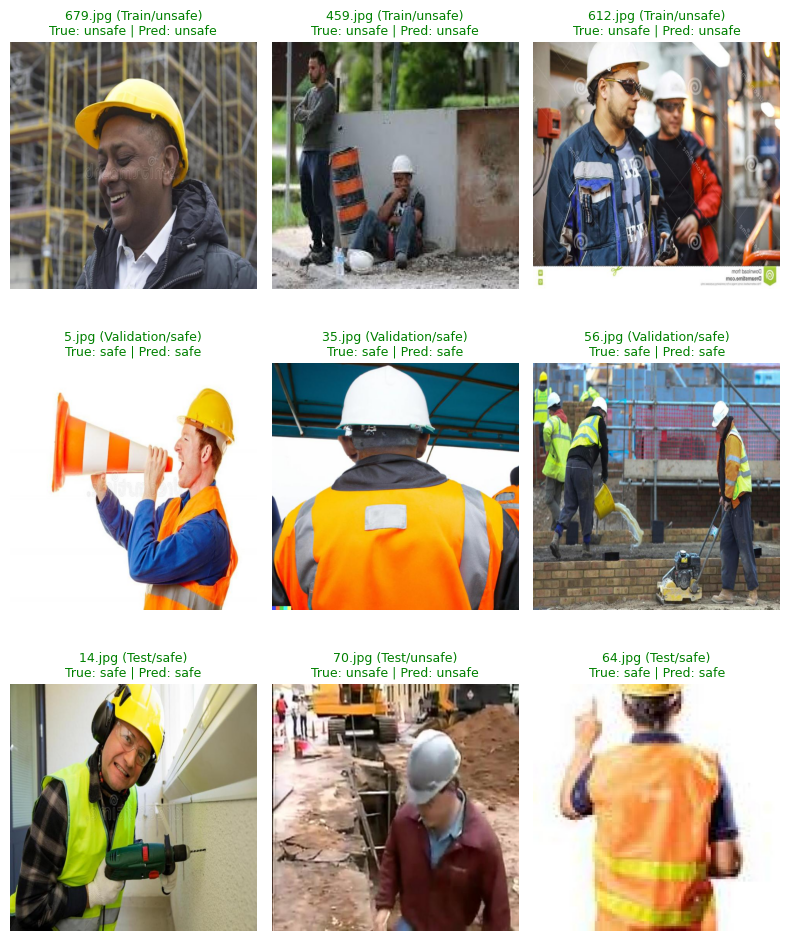

In [ ]:
show_predictions_grid(loaded_model, transform)

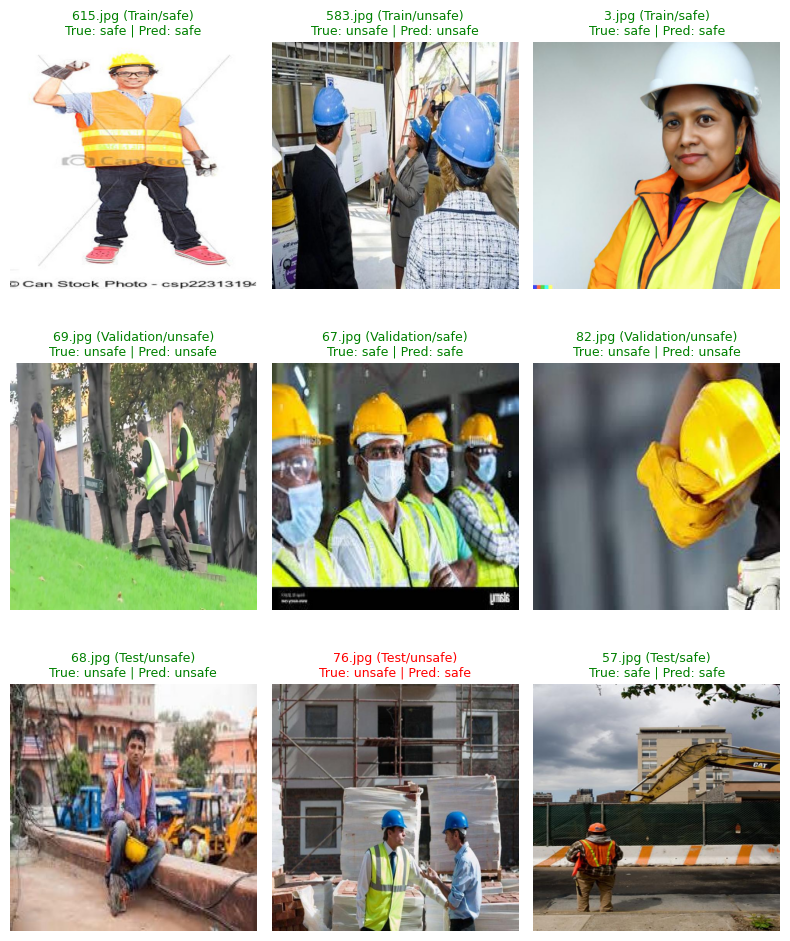

In [ ]:
show_predictions_grid(loaded_model, transform)

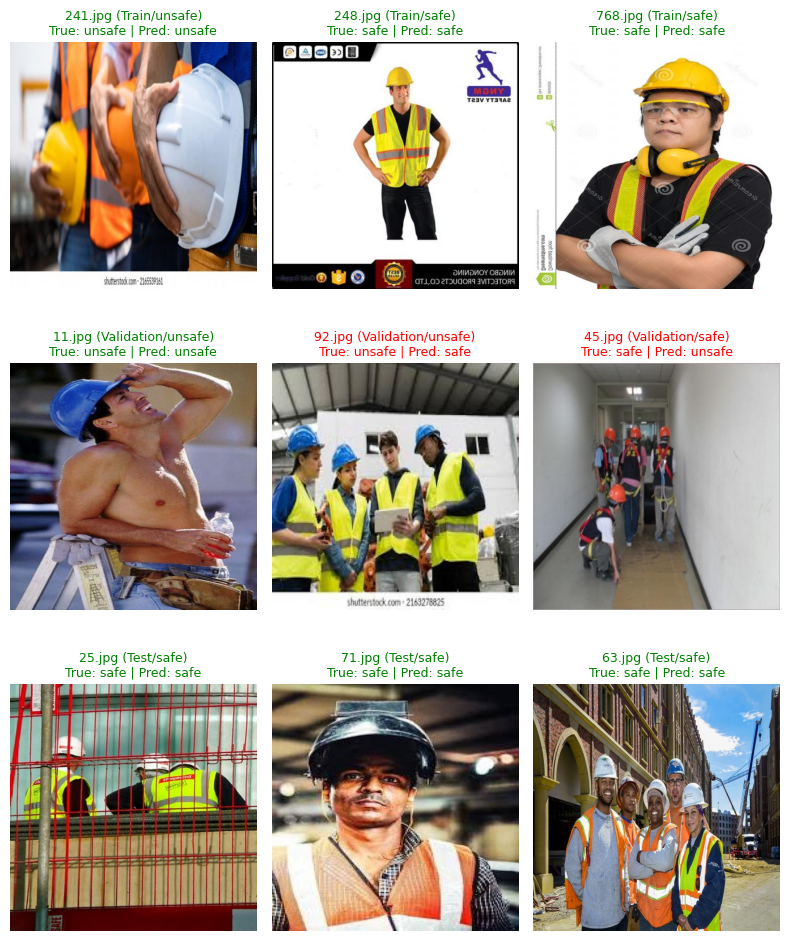

In [ ]:
show_predictions_grid(loaded_model, transform)